In [13]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split

# Data

In [14]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:, 1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

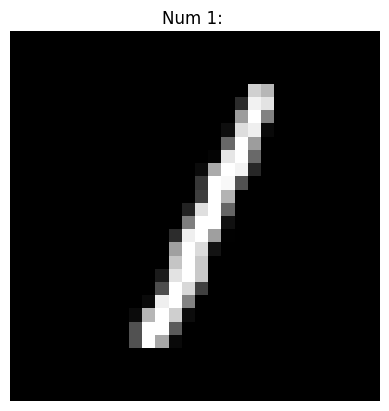

In [15]:
rand_row = np.random.randint(data.shape[0])
img = np.reshape(data_norm[rand_row], (28,28))
num = labels[rand_row]

plt.imshow(img, cmap = 'grey')
plt.title('Num %d: '%num)
plt.axis(False)
plt.show()

# Split

In [16]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [17]:
def ModelCreate(n_layers, n_units):

  class ModelArch(nn.Module):
    def __init__(self, n_layers, n_units):
      super().__init__()

      self.n_layers = n_layers
      self.layers = nn.ModuleDict()

      # Layers
      self.layers['input'] = nn.Linear(784, n_units)

      for i in range(n_layers):
        self.layers[f'hidden_{i}'] = nn.Linear(n_units, n_units)

      self.layers['output'] = nn.Linear(n_units, 10)

    def forward(self, x):
      x = self.layers['input'](x)

      for i in range(self.n_layers):
        x = self.layers[f'hidden_{i}'](x)

      x = self.layers['output'](x)

      return x

  ann = ModelArch(n_layers, n_units)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-2)

  return ann, loss_fn, optimizer

In [18]:
ann, loss_fn, optimizer = ModelCreate(n_layers = 2, n_units = 64)
X, y = next(iter(train_dataloader))
y_hat = ann(X)
loss = loss_fn(y_hat, y)
loss

tensor(2.3037, grad_fn=<NllLossBackward0>)

# Train

In [19]:
def ModelTrain(epochs, n_layers, n_units, verbose):
  net, loss_fn, optimizer = ModelCreate(n_layers, n_units)

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs

In [20]:
train_accs, test_accs = ModelTrain(epochs = 100, n_layers = 2, n_units = 64, verbose = True)

Epoch: 0 | Train Acc: 29.27 | Test Acc: 52.62 | Loss: 2.24
Epoch: 10 | Train Acc: 89.32 | Test Acc: 88.80 | Loss: 0.37
Epoch: 20 | Train Acc: 91.50 | Test Acc: 90.80 | Loss: 0.30
Epoch: 30 | Train Acc: 92.41 | Test Acc: 90.90 | Loss: 0.27
Epoch: 40 | Train Acc: 92.91 | Test Acc: 91.30 | Loss: 0.25
Epoch: 50 | Train Acc: 93.17 | Test Acc: 91.45 | Loss: 0.24
Epoch: 60 | Train Acc: 93.61 | Test Acc: 91.45 | Loss: 0.23
Epoch: 70 | Train Acc: 93.72 | Test Acc: 91.35 | Loss: 0.22
Epoch: 80 | Train Acc: 93.98 | Test Acc: 91.20 | Loss: 0.21
Epoch: 90 | Train Acc: 94.27 | Test Acc: 91.35 | Loss: 0.21


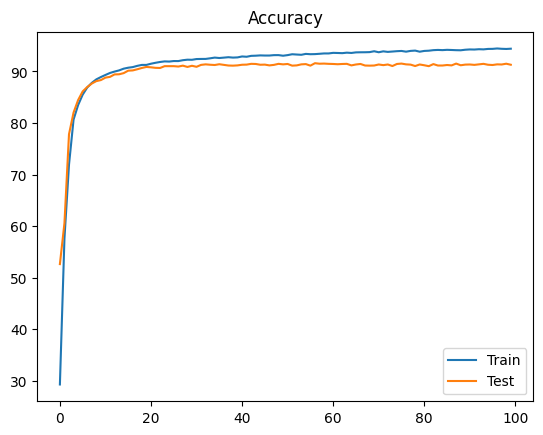

In [21]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['Train', 'Test'])
plt.title('Accuracy')
plt.show()

# Experiment

In [22]:
n_layers_op = [1,2,3]
n_units_op = torch.linspace(50,250,5)
epochs = 100

ex_train_accs = torch.zeros((epochs, len(n_layers_op), len(n_units_op)))
ex_test_accs = torch.zeros((epochs, len(n_layers_op), len(n_units_op)))

for n_layers_idx, n_layers in enumerate(n_layers_op):
  for n_units_idx, n_units in enumerate(n_units_op):
    print(f'\n\nProcessing n_layers: {n_layers}, n_units: {n_units}')
    train_accs, test_accs = ModelTrain(epochs = epochs, n_layers = n_layers, n_units = int(n_units), verbose = True)

    ex_train_accs[:, n_layers_idx, n_units_idx] = torch.tensor(train_accs)
    ex_test_accs[:, n_layers_idx, n_units_idx] = torch.tensor(test_accs)



Processing n_layers: 1, n_units: 50.0
Epoch: 0 | Train Acc: 45.91 | Test Acc: 63.90 | Loss: 2.09
Epoch: 10 | Train Acc: 89.78 | Test Acc: 89.05 | Loss: 0.36
Epoch: 20 | Train Acc: 91.49 | Test Acc: 90.60 | Loss: 0.30
Epoch: 30 | Train Acc: 92.16 | Test Acc: 90.95 | Loss: 0.28
Epoch: 40 | Train Acc: 92.69 | Test Acc: 91.20 | Loss: 0.26
Epoch: 50 | Train Acc: 92.95 | Test Acc: 91.38 | Loss: 0.25
Epoch: 60 | Train Acc: 93.24 | Test Acc: 91.47 | Loss: 0.24
Epoch: 70 | Train Acc: 93.46 | Test Acc: 91.53 | Loss: 0.23
Epoch: 80 | Train Acc: 93.61 | Test Acc: 91.58 | Loss: 0.23
Epoch: 90 | Train Acc: 93.88 | Test Acc: 91.33 | Loss: 0.22


Processing n_layers: 1, n_units: 100.0
Epoch: 0 | Train Acc: 48.91 | Test Acc: 70.28 | Loss: 2.05
Epoch: 10 | Train Acc: 90.03 | Test Acc: 89.60 | Loss: 0.35
Epoch: 20 | Train Acc: 91.58 | Test Acc: 91.00 | Loss: 0.30
Epoch: 30 | Train Acc: 92.26 | Test Acc: 91.22 | Loss: 0.27
Epoch: 40 | Train Acc: 92.67 | Test Acc: 91.35 | Loss: 0.26
Epoch: 50 | Train Acc

# Plots

In [23]:
import matplotlib.pyplot as plt
import mplcursors

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for n_layers_idx, n_layers in enumerate(n_layers_op):
    for n_units_idx, n_units in enumerate(n_units_op):
        label = f"n_layers={n_layers}, n_units={int(n_units)}"

        ax[0].plot(ex_train_accs[:, n_layers_idx, n_units_idx],
                   label=label, alpha=0.8, linewidth=1.5)
        ax[1].plot(ex_test_accs[:, n_layers_idx, n_units_idx],
                   label=label, alpha=0.8, linewidth=1.5)

for a, title in zip(ax, ["Train Accuracy", "Test Accuracy"]):
    a.set_xlabel("Epochs")
    a.set_ylabel("Accuracy (%)")
    a.set_title(title)
    a.grid(alpha=0.2)

# mała legenda z boku (nie zasłania wykresu)
ax[1].legend(fontsize=7, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
mplcursors.cursor(hover=True)
plt.show()


ModuleNotFoundError: No module named 'mplcursors'

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
for n_layers_idx, n_layers in enumerate(n_layers_op):
  for n_units_idx, n_units in enumerate(n_units_op):
    ax[0].plot(ex_train_accs[:,n_layers_idx,int(n_units)], label = f'n_layers: {n_layers}, n_units: {n_units}')
    # ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Train Accuracy')
    ax[0].set_ylim([84,101])

    ax[1].plot(ex_test_accs[:,n_layers_idx,int(n_units)], label = f'n_layers: {n_layers}, n_units: {n_units}')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test Accuracy')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

for n_layers_idx, n_layers in enumerate(n_layers_op):
    mean_train_acc = ex_train_accs[-5:, n_layers_idx, :].mean(dim=0)
    ax[0].plot(n_units_op, mean_train_acc, marker='o', label=f'n_layers: {n_layers}')

ax[0].set_xlabel('Number of Units')
ax[0].set_ylabel('Mean Train Accuracy (last 5 epochs)')
ax[0].set_title('Effect of Units on Train Accuracy')
ax[0].legend()
ax[0].set_ylim([84,101])

for n_units_idx, n_units in enumerate(n_units_op):
    mean_test_acc = ex_test_accs[-5:, :, n_units_idx].mean(dim=0)
    ax[1].plot(n_layers_op, mean_test_acc, marker='o', label=f'n_units: {int(n_units)}')

ax[1].set_xlabel('Number of Layers')
ax[1].set_ylabel('Mean Test Accuracy (last 5 epochs)')
ax[1].set_title('Effect of Layers on Test Accuracy')
ax[1].legend()
ax[1].set_ylim([84,101])

plt.tight_layout()
plt.show()
